In [1]:
import pandas as pd
import tokenizers
import glob
import os
import torch
from torch.utils.data import Dataset, DataLoader

import sentencepiece as spm

## Make .txt files

In [2]:
# files = glob.glob("./data/GYAFC_Corpus/Family_Relationships/tune/*")
# files

In [3]:
# for fi in files:
#     file = open(fi, "r", encoding="utf8")
#     for line in file.readlines():
#         with open(f"{fi}_fr_tune.txt", "a", encoding="utf8") as f:
#             if line != "\n":
#                 f.write(line)

## Load txt files

In [158]:
formal_file = './data/processed/raw/fr_formal_train.txt'
informal_file = './data/processed/raw/fr_informal_train.txt'

In [164]:
total_df = pd.DataFrame()
formal_df = pd.read_fwf(formal_file, header=None)
formal_df = formal_df.drop(1, axis=1)
formal_df.columns = ['formal']
informal_df = pd.read_fwf(informal_file, header=None)
informal_df = informal_df.drop([1, 2, 3, 4, 5], axis=1)
informal_df.columns = ['informal']

print(formal_df.shape, informal_df.shape)
total_df = pd.concat([formal_df, informal_df], axis=1)

(51967, 1) (51967, 1)


In [165]:
print(total_df.shape)
total_df.to_csv("./data/processed/raw/fr_train_pair.csv", index=False)
total_df.tail()

(51967, 2)


,formal,informal
51962,"Of course, it depends on what type of relation...",of corse it depends on what relation u r looki...
51963,"Wear a sign that say ""Hi!""",Wear a sign that says Hi!
51964,I do not like when guys play games with me.,"I don't believe in playing games, I hate when ..."
51965,How old are you?,(or w/e) p.s gurl how old r u ?
51966,"If you watch her, you might be able to learn w...",Try to watch her to see what kind of things sh...


## 모델 하이퍼파라미터 설정
### 모델의 hyperparameter를 string으로 정의해 줍니다.
- **character_coverage**: 얼마나 자소단위 셋을 줄여 단어단위 셋으로 coverage 시킬 것인지에 대한 모델 하이퍼파라미터
- 실험적으로
    + 중국어, 일본어 같이 자소단위로 이루어진 언어(rich character set)에서는 0.9995
    + 다른언어(small character set)에 대해서 1로 설정

In [167]:
parameter = '--input={} \
--pad_id={} --pad_piece={} \
--bos_id={} --bos_piece={} \
--eos_id={} --eos_piece={} \
--unk_id={} --unk_piece={} \
--user_defined_symbols={} \
--model_prefix={} \
--vocab_size={} \
--max_sentence_length={} \
--character_coverage={} \
--model_type={}'

train_input_file = "./data/processed/raw/em_formal_train.txt"
pad_id = 0
pad_piece = "[PAD]"
bos_id = 1
bos_piece = "[BOS]"
eos_id = 2
eos_piece = "[EOS]"
unk_id = 3
unk_piece = "[UNK]"
user_defined_symbols = "[SEP],[CLS],[MASK]"
prefix = './data/tokenizer/em_formal_spm'
vocab_size = 2000
max_sentence_length = 9999
character_coverage = 1.0 # default 
model_type = 'unigram' # default: unigram


cmd = parameter.format(train_input_file, 
                       pad_id, pad_piece,
                       bos_id, bos_piece, 
                       eos_id, eos_piece, 
                       unk_id, unk_piece,
                       user_defined_symbols,
                       prefix,
                       vocab_size,
                       max_sentence_length,
                       character_coverage,
                       model_type)

cmd

'--input=./data/processed/raw/em_formal_train.txt --pad_id=0 --pad_piece=[PAD] --bos_id=1 --bos_piece=[BOS] --eos_id=2 --eos_piece=[EOS] --unk_id=3 --unk_piece=[UNK] --user_defined_symbols=[SEP],[CLS],[MASK] --model_prefix=./data/tokenizer/formal_em_spm --vocab_size=2000 --max_sentence_length=9999 --character_coverage=1.0 --model_type=unigram'

## Tokenizer 학습
- 학습이 잘 완료되면 True라는 인자를 반환합니다.
- 이부분이 완료되면, prefix를 가진 아래의 두개의 파일이 생성됩니다.
    + model:실제로 사용되는 tokenizer 모델
    + vocab: 참조하는 단어집합

├── {prefix}.model  
├── {prefix}.vocab  

In [170]:
spm.SentencePieceTrainer.Train(cmd)

## 문장에 Tokenizer 적용
- 이제 실제 문장에 적용하기 위해서 sp모듈 새로 정의해, 이전에 학습한 {prefix}.model을 불러옵니다.

In [125]:
sp = spm.SentencePieceProcessor()
sp.Load(f"{prefix}.model")

True

### {prefix}.vocab 불러오기

In [126]:
with open(f'{prefix}.vocab', encoding='utf-8') as f:
    Vo = [doc.strip().split("\t") for doc in f]

# w[0]: token name    
# w[1]: token score
word2idx = {w[0]: i for i, w in enumerate(Vo)}

In [129]:
# word2idx

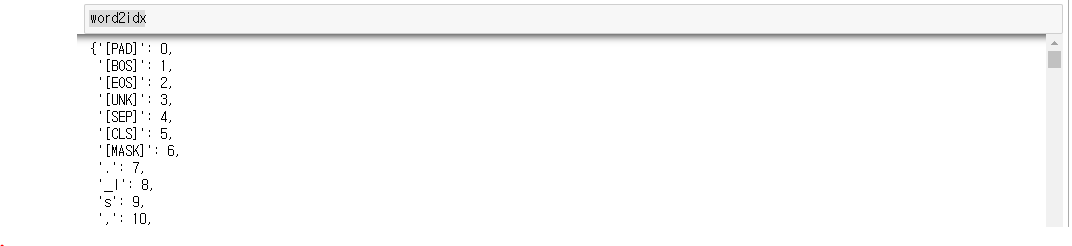

- Tokenize하기 전에 데이터 자체에 **\<s>, \</s>**를 넣어줘도 되지만, 패키지 자체에서 알아서 해주는 옵션(sp.SetEncodeExtraOptions)이 있습니다.

In [115]:
sp.SetEncodeExtraOptions('bos:eos')

True

## Tokenizer 수행
- EncodeAsPieces: string으로 tokenize
- EncodeAsIds: ids으로 tokenize

In [116]:
tokens = sp.EncodeAsPieces('This eBook is for the use of anyone anywhere at no cost')
tokens

['[BOS]',
 '▁This',
 '▁e',
 'B',
 'ook',
 '▁is',
 '▁for',
 '▁the',
 '▁use',
 '▁of',
 '▁anyone',
 '▁any',
 'where',
 '▁at',
 '▁no',
 '▁cost',
 '[EOS]']

In [117]:
tokensIds = sp.EncodeAsIds('This eBook is for the use of anyone anywhere at no cost')
tokensIds

[1, 234, 212, 284, 722, 9, 35, 8, 317, 19, 634, 178, 917, 90, 126, 1276, 2]

## Decode Token 
- 위에서 쪼개진 token들을 그냥 공백기준으로 붙이면 _와 띄어쓰기 모호함에 따라 어색함이 생길 수 있습니다.
- sp내의 Decode함수를 사용하면 쉽게 원복할 수 있습니다.


In [118]:
sp.DecodePieces(tokens)

'This eBook is for the use of anyone anywhere at no cost'

In [120]:
sp.DecodeIds(tokensIds)

'This eBook is for the use of anyone anywhere at no cost'

----------------

In [121]:
vocab = sp
dt = ['There are not cursed movies or weird things!', 'Do you want to learn the lyrics or actually meet them?', 'I am not sure yet.', 'That is how good it is.', 'Who cares about the Top 20 Celebrity Moments on Vh1?', 'I also like the show Friends.  Pheobe and Joey make it a very funny show.', 'The girls stopped gossiping about it so they no longer make it.', 'I would go to jail if I did it.', 'Ciara and Bow Wow', 'I do not believe he can cure anything, however.', 'You have exposed me which I thought would never happen. Why did you do this?', 'Veronica. Not only do I love brunettes, but she is from an extremely wealthy family.', 'You could learn more information with a Yahoo search.', 'The two sites are: Limewire (www.limewire.com), and Kazaa (www.kazaa.com).', 'Dogs enjoy lunch. Men enjoy pleasing woman.', 'The two least popular were Bye Kelly and Paris.', 'I would have to choose Pink Floyd.', 'What in the world, there is only one Titanic so why make a second movie?', 'I think you are talking about Perth in Western Australia.', 'You are a good songwriter.', 'If you have not had the opportunity to read the books, they are great and accessible for anybody interested.', 'Scary Movies one, two, three, and (as of April 4th) four.', 'The soviet dog, "Layka", was the first dog to go to space.', 'And what does their team actually do?', "Oh course he is, don't pay Jennisfer any mind, she has no fun.", 'Many different kinds of people like cartoons and draw them, not just stereotypical geeks. Everyone is different.', 'I had intimacy with an animal once.', 'I would say yes because I am somewhat certain that it is the same person.', 'I love that song as well, therefore I acquired their greatest hits compact disc.', 'I find I am beginning to like Nathan.', 'A woodchuck cannot chuck or eat wood.', 'He became a full demon in the second film, but she kissed him. The kiss made him revert back to normal.']

In [122]:
vocab.EncodeAsIds(dt[1].strip())

[1, 170, 12, 155, 10, 857, 8, 464, 68, 840, 1363, 98, 30, 2]

In [91]:
class CustomDataset(Dataset):
    def __init__(self, data, vocab: vocab):
        self.data = data
        self.vocab = vocab

        
    def __getitem__(self, idx):
        return self.vocab.EncodeAsIds(self.data[idx].strip())

    
    def __len__(self):
        return len(self.data)
    
    def __iter__(self):
        for x in self.data:
            yield x
    
    def get_vocab(self):
        return self.vocab
    
    def decode(self, x):
        return self.vocab.DecodeIds(x)

        

In [92]:
formal_data = total_df["formal"].tolist()
informal_data = total_df["informal"].tolist()
print(len(formal_data), len(informal_data))

52595 52595


In [93]:
dataloader = DataLoader(formal_data, batch_size=32, shuffle=True)

In [94]:
for batch, data in enumerate(dataloader):
    print(data)
    print(len(data))
    print(data.__getitem__(1))
    break

['Garbage Man, Geraldine McEwan is Miss Scattergoods, Christopher Nee', 'After one year it is converted to a movie.  It is 45 years old, and started with the writer in mind.', 'It is simply demonstrating that adults investigate things excessively.', "Get your own so you don't have to waste your time watching this!", 'Unexpectedly, I have a shitload.', 'Working for others is not what I want to do.', 'I do not believe she is involved with it in any way.', 'These are not websites, they are programs on which you can share mp3s, etc.: limewire, eMule, and ares.', 'Bob wrote most of his song on this piano.', 'I dislike christian influence music. You should try out bands like Kittie, Helalyn Flowers, and Arch Enemy.', 'He cannot. He is too busy playing basketball.', 'A shipment of breast implants arrived at his house.', 'Ruining endings, and being critical reduces the fun of situations.', 'He did not, he simply took some time off work to help Hallie and improve his lifestyle.', 'I have tried 

In [ ]:
#     def __init__(self, data, voacb: spm.SentencePieceProcessor, sep_id: str="[SEP]", cls_id: str="[CLS]",
#                  mask_id: str="[MASK]", pad_id: str="[PAD]", seq_len: int=512, mask_frac: float=0.15, p: float=0.5):
#         super(CustomDataset, self).__init__()
#         self.voacb = vocab
#         self.data = data
#         self.seq_len = seq_len
#         self.sep_id = vocab.piece_to_id(sep_id)
#         self.cls_id = vocab.piece_to_id(cls_id)
#         self.mask_id = voacb.piece_to_id(mask_id)
#         self.pad_id = vocab.piece_to_id(pad_id)
#         self.p = p
#         self.mask_frac = mask_frac



#     def __getitem__(self, i):
#         seq1 = self.vocab.EncodeAsIds(self.data[i].strip())
#         seq2_idx = i+1
#         # decide wheter use random next sentence or not for NSP task
#         if random.random() > p:
#             is_next = torch.tensor(1)
#             while seq2_idx == i+1:
#                 seq2_idx = random.randint(0, len(data))
#         else:
#             is_next = torch.tensor(0)

#         seq2 = self.vocab.EncodeAsIds(self.data[seq2_idx])

#         if len(seq1) + len(seq2) >= self.seq_len - 3: # except 1 [CLS] and 2 [SEP]
#             idx = self.seq_len - 3 - len(seq1)
#             seq2 = seq2[:idx]

#         # sentence embedding: 0 for A, 1 for B
#         mlm_target = torch.tensor([self.cls_id] + seq1 + [self.sep_id] + seq2 + [self.sep_id] + [self.pad_id] * (self.seq_len - 3 - len(seq1) - len(seq2))).long().contiguous()
#         sent_emb = torch.ones((mlm_target.size(0)))
#         _idx = len(seq1) + 2
#         sent_emb[:_idx] = 0
        
#         def masking(data):
#             data = torch.tensor(data).long().contiguous()
#             data_len = data.size(0)
#             ones_num = int(data_len * self.mask_frac)
#             zeros_num = data_len - ones_num
#             lm_mask = torch.cat([torch.zeros(zeros_num), torch.ones(ones_num)])
#             lm_mask = lm_mask[torch.randperm(data_len)]
#             data = data.masked_fill(lm_mask.bool(), self.mask_id)

#             return data

#         mlm_train = torch.cat([torch.tensor([self.cls_id]), masking(seq1), torch.tensor([self.sep_id]), masking(seq1), torch.tensor([self.sep_id])]).long().contiguous()
#         mlm_train = torch.cat([mlm_train, torch.tensor([self.pad_id] * (512 - mlm_train.size(0)))]).long().contiguous()

#         # mlm_train, mlm_target, sentence embedding, NSP target
#         return mlm_train, mlm_target, sent_emb, is_next
#         # return self.data[i]

In [1]:
import pandas as pd
import tokenizers
import glob
import os
import torch
from torch.utils.data import Dataset, DataLoader

import sentencepiece as spm

In [70]:
tokenizer = spm.SentencePieceProcessor()
tokenizer.Load("./data/tokenizer/train_em_formal_spm.model")

True

In [39]:
sdf = [[47, 84, 636], [372, 345, 874]]

In [69]:
[tokenizer.DecodeIds(i) for i in c]

['']

In [38]:
a = (torch.rand(2, 2)*10)
print(a.tolist())
a

[[4.752358913421631, 8.410636901855469], [3.7723755836486816, 3.640380382537842]]


tensor([[4.7524, 8.4106],
        [3.7724, 3.6404]])

In [11]:
a.argmax()

tensor([[1, 0, 0],
        [0, 0, 1]])

In [90]:
b = torch.rand(2, 10)
b[:, 1:].tolist()

[[0.5248565673828125,
  0.8026675581932068,
  0.04119044542312622,
  0.3099430203437805,
  0.7548211216926575,
  0.49521517753601074,
  0.5619834661483765,
  0.5527728796005249,
  0.9217063188552856],
 [0.13436448574066162,
  0.7198908925056458,
  0.32315880060195923,
  0.49836790561676025,
  0.9914924502372742,
  0.2773929238319397,
  0.4438886046409607,
  0.8123650550842285,
  0.48424428701400757]]

In [94]:

c = [("a,", "b")]
for i, j in c:
    print(i)
    print(j)

a,
b


In [79]:
b =torch.argmax(b, dim=1).tolist()
print(b)
c.append(b)
c

[7, 3]


[[7, 3]]

In [80]:
[tokenizer.DecodeIds(i) for i in c]

['. ⁇ ']

In [23]:
c = torch.rand(3)
d = torch.rand(3)
c.size()

torch.Size([3])

In [24]:
e = c.tolist()
f = d.tolist()
x = []
x.append(e)
x.append(f)
print(x)

[[0.3908649682998657, 0.9498142600059509, 0.8346061706542969], [0.6791485548019409, 0.5381976366043091, 0.7374628782272339]]


In [26]:
list(map(list, zip(*x)))

[[0.3908649682998657, 0.6791485548019409],
 [0.9498142600059509, 0.5381976366043091],
 [0.8346061706542969, 0.7374628782272339]]

In [95]:
a = torch.rand([4, 10, 24])
b = torch.rand([4, 10, 24])
c = torch.cat((a, b), -1)
c.size()

torch.Size([4, 10, 48])